In [1]:
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
cody = pd.read_csv('weight.csv')
cody.head()

,date,lbs,oz
0,2017-07-19,9,10.0
1,2017-07-11,9,0.5
2,2017-07-10,8,14.0
3,2017-07-07,8,13.0
4,2017-07-03,8,0.0


In [3]:
cody = cody.astype({'date': 'datetime64[ns]',
               'lbs': 'float64',
               'oz': 'float64'})
cody['weight'] = cody['lbs'] + cody['oz'] / 16.0
cody['epoch'] = cody['date'].astype('int64') // 1e9
cody['days'] = ((cody['date'] - pd.datetime(2017, 6, 28)) / np.timedelta64(1, 'D')).astype(int)

# sort by days since birth
cody = cody.sort_values('days')

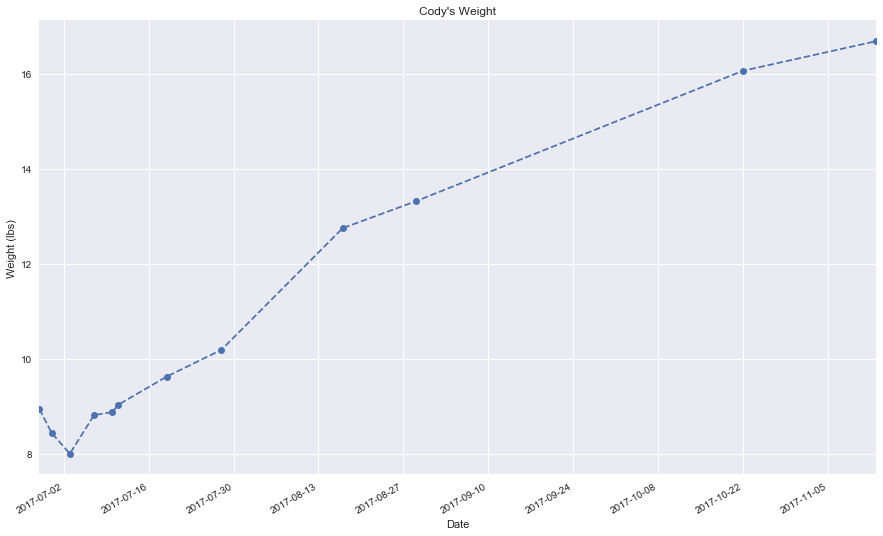

In [4]:
figdim = 15
ax = cody.plot(x='date', y='weight',
             title='Cody\'s Weight',
             legend=False,
             figsize=(figdim, 0.618 * figdim),
             linestyle='--',
             marker='o')
ax.set(ylabel='Weight (lbs)', xlabel='Date');

## Simulating Cody's Weight

Cody's weight has followed a fairly linear process from the nadir around July 4th.

\begin{align}
w &\sim \mathcal{N}\left(\mu, \sigma^{2}\right) \\
\mu &= \alpha + \beta X_{1} \\
\alpha &\sim \mathcal{N}\left(0, 1\right) \\
\beta &\sim \mathcal{N}\left(0, 1\right) \\
\sigma &\sim \left|\,\mathcal{N}\left(0, 0.1\right)\,\right|
\end{align}

In [5]:
import pymc3
import numpy as np

basic_model = pymc3.Model()

# exclude days before he started gaining weight
start = 2

with basic_model:

    # Priors for unknown model parameters
    alpha = pymc3.Normal('alpha', mu=0, sd=1)
    beta = pymc3.Normal('beta', mu=0, sd=1)
    sigma = pymc3.HalfNormal('sigma', sd=0.1)

    # Expected value of outcome
    mu = alpha + beta * cody['days'].values[start:]

    # Likelihood (sampling distribution) of observations
    Y_obs = pymc3.Normal('Y_obs', mu=mu, sd=sigma, observed=cody['weight'].values[start:])

In [6]:
from scipy import optimize
map_estimate = pymc3.find_MAP(model=basic_model)
map_estimate

Optimization terminated successfully.
         Current function value: 52.027833
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 50


{'alpha': array(8.073429081273476),
 'beta': array(0.06892116549280622),
 'sigma_log__': array(-0.9609357938422197)}

In [7]:
from scipy import optimize
with basic_model:

    # obtain starting values via MAP
    start = pymc3.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pymc3.Slice()

    # draw 5000 posterior samples
    trace = pymc3.sample(10000, step=step, start=start)

  0%|          | 14/10500 [00:00<01:15, 138.43it/s]

Optimization terminated successfully.
         Current function value: 52.027833
         Iterations: 8
         Function evaluations: 290


100%|██████████| 10500/10500 [00:31<00:00, 330.86it/s]


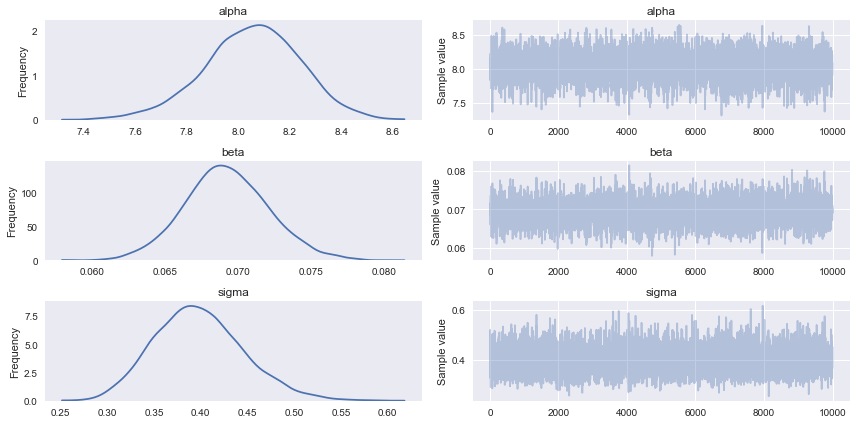

In [8]:
_ = pymc3.traceplot(trace)

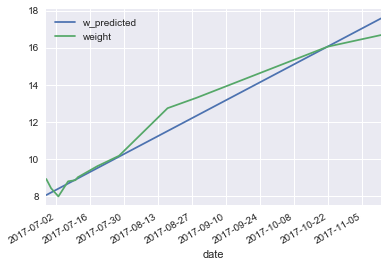

In [9]:
cody['w_predicted'] = float(map_estimate['alpha']) + float(map_estimate['beta']) * cody['days']
cody.plot(x='date', y=['w_predicted', 'weight'])

In [11]:
(pd.datetime(2017, 12, 28) - pd.datetime(2017, 6, 28))
float(map_estimate['alpha']) + float(map_estimate['beta']) * 122

16.481811271395834

## CDC charts

In [12]:
%matplotlib inline
import pandas as pd
df = pd.read_html('https://www.cdc.gov/growthcharts/html_charts/wtageinf.htm', 'Males, Birth – 36 Months',
                  header=0, index_col='Age (in months)')[0]
df.columns = [col[:-22] for col in df.columns]
df.head(10)

,3rd Percentile,5th Percentile,10th Percentile,25th Percentile,50th Percentile,75th Percentile,90th Percentile,95th Percentile,97th Percentile
Age (in months),,,,,,,,,
0.0,2.355451,2.526904,2.773802,3.150611,3.530203,3.879077,4.172493,4.340293,4.446488
0.5,2.799549,2.964656,3.209510,3.597396,4.003106,4.387423,4.718161,4.910130,5.032625
1.5,3.614688,3.774849,4.020561,4.428873,4.879525,5.327328,5.728153,5.967102,6.121929
2.5,4.342341,4.503255,4.754479,5.183378,5.672889,6.175598,6.638979,6.921119,7.106250
3.5,4.992898,5.157412,5.416803,5.866806,6.391392,6.942217,7.460702,7.781401,7.993878
4.5,5.575169,5.744752,6.013716,6.484969,7.041836,7.635323,8.202193,8.556813,8.793444
5.5,6.096775,6.272175,6.551379,7.043627,7.630425,8.262033,8.871384,9.255615,9.513307
6.5,6.564430,6.745993,7.035656,7.548346,8.162951,8.828786,9.475466,9.885436,10.161350
7.5,6.984123,7.171952,7.472021,8.004399,8.644832,9.341490,10.021010,10.453310,10.744920


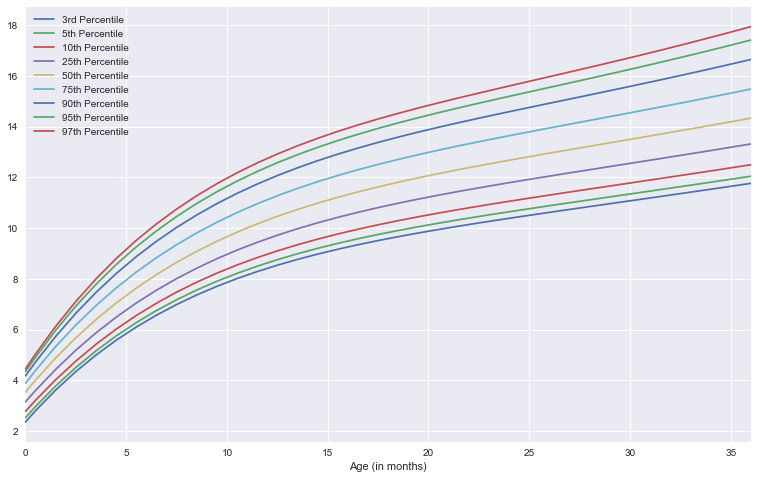

In [13]:
ax = df.plot(figsize=(13, 8))